# ASAP 2.0 analyses

Purpose

    - Develop LLM scoring models for the ASAP 2.0 data using a Fine-tuned transformer.

Using deberta 3 large

    - With Roberta large as a back up

We have two approaches here

1. Finetuned model without hyperparametrization
2. Finetuned model with hyperparametrization


## Dataset is ASAP 2.0.

https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/data

But the dataset includes all the data.

~25,000 source-based essays

Scored from 1-6

Training and test sets defined

A variety of demographic information available including

  - economic disadvantage
  - disability (both gifted and challenged)
  - ELL
  - Race
  - Gender
  - Grade

## Install Packages

If you use the hugging_face environment, you will not need to install packages

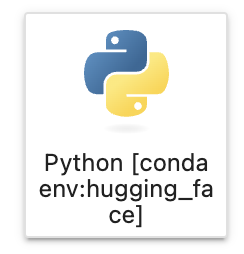

This was set up using this [link](https://github.com/learlab/development-server/wiki/Using-JupyterHub#virtual-environments-in-python)

In [ ]:

#!pip install transformers[torch]
#!pip install --quiet transformers[torch] #datasets evaluate pingouin


## Import packages

In [ ]:
#install transformers and other packages that might not exist
#!pip install transformers
#!pip install datasets
#!pip install evaluate
#!pip install transformers[sentencepiece]

In [5]:
#had some problems and needed to upgrade some stuff

#!pip install --upgrade pyarrow
#!pip uninstall -y datasets
#!pip install datasets

Found existing installation: datasets 2.21.0
Uninstalling datasets-2.21.0:
  Successfully uninstalled datasets-2.21.0
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)


In [2]:
#!pip install scikit-learn


#import libraries that are not problematic

import pandas as pd # You know what this is
import sklearn
import numpy as np # Numpy is for whenever you have numbers in Python
import seaborn as sns # Plotting library based on MatPlotLib
from scipy import stats # Statistical distributions, functions, and a few tests
from IPython.display import display # print(), but for HTML output (like Pandas dataframes)

In [3]:
# The following packages and modules are all from HuggingFace

# A class for managing data with lots of useful features for model training
#!pip install --upgrade datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# The following packages and modules are all from HuggingFace

# We import four classes from transformers.
from transformers import (
    # All language models start with tokens (by definition)
    AutoTokenizer,
    # Convenience class for creating and using transformer-based sequence classifiers
    AutoModelForSequenceClassification,
    # Configuration class for managing, you guessed it, training arguments
    TrainingArguments,
    # A class that abstracts away the PyTorch training loop.
    Trainer,
    # A data collator organizes (collates) the data into batches for training
    # It will also add special [PAD] tokens to make all the sequences in a batch the same length
    # Batches with equal-length sequences make our GPU go brr
    DataCollatorWithPadding,
    DefaultDataCollator
)

# A library for performance evaluations metrics
# Especially useful for complex and task-specific metrics
# For example, the GLUE metric can score language models on a suite of popular benchmarks
# But we will just use some simple metrics today
import evaluate

# Pipelines are used to streamline tokenization and inference
# We will create a pipeline after finetuning!
from transformers import pipeline





## Load and Prepare ASAP Corpus

In [5]:
asap_df = (
    pd.read_csv("ASAP2_competitiondf_with-metadata.csv"))

asap_df

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task
0,AAAVUP14319000159574,4,The author suggests that studying Venus is wor...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Identified as having disability,No,Black/African American,F,10.0,409.0,PERSUADE,Text dependent
1,AAAVUP14319000159542,2,NASA is fighting to be alble to to go to Venus...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,10.0,197.0,PERSUADE,Text dependent
2,AAAVUP14319000159461,3,"""The Evening Star"", is one of the brightest po...",test,private,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Identified as having disability,No,White,M,10.0,361.0,MI,Text dependent
3,AAAVUP14319000159420,2,The author supports this idea because from rea...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,F,10.0,209.0,MI,Text dependent
4,AAAVUP14319000159419,2,How the author supports this idea is that he s...,train,0,"In ""The Challenge of Exploring Venus,"" the aut...",Exploring Venus,Economically disadvantaged,Not identified as having disability,Yes,Hispanic/Latino,M,10.0,214.0,MI,Text dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24723,5022045,3,Everyone should have an opinion on what they t...,train,0,Write a letter to your state senator in which ...,Does the electoral college work?,NaN,NaN,No,Asian/Pacific Islander,M,9.0,355.0,PERSUADE,Text dependent
24724,5022027,4,The debate on the pros and cons of car usage h...,train,0,Write an explanatory essay to inform fellow ci...,Car-free cities,NaN,NaN,No,Hispanic/Latino,F,10.0,303.0,PERSUADE,Text dependent
24725,5022023,1,dear senator:\n\nthe electoral college most be...,train,0,Write a letter to your state senator in which ...,Does the electoral college work?,NaN,NaN,Yes,Hispanic/Latino,F,9.0,256.0,PERSUADE,Text dependent
24726,5022018,2,"New cars are invented almost everyday, some ar...",train,0,Write an explanatory essay to inform fellow ci...,Car-free cities,NaN,NaN,No,Hispanic/Latino,F,10.0,253.0,PERSUADE,Text dependent


### Basic descriptives

In [ ]:
#number of words

mean_nw = asap_df['essay_word_count'].mean()
sd_nw = asap_df['essay_word_count'].std()
max_nw = asap_df['essay_word_count'].max()

print(f'mean number of words = {mean_nw}')
print(f'sd for number of words = {sd_nw}')
print(f'max for number of words = {max_nw}')


#how many essays are greated than 512 words? (almost 4k)

llm_max = 512

llm_over = (asap_df['essay_word_count'] > llm_max).sum()
print(f'essays that are over 512 word = {llm_over}')


In [ ]:
#statistics on the data itself

prompt_count = asap_df['prompt_name'].value_counts()
ed_count = asap_df['economically_disadvantaged'].value_counts()
sd_count = asap_df['student_disability_status'].value_counts()
ell_count = asap_df['ell_status'].value_counts()
re_count = asap_df['race_ethnicity'].value_counts()
gen_count = asap_df['gender'].value_counts()
grade_count = asap_df['grade_level'].value_counts()

print(prompt_count)
print("\n")
print(ed_count)
print("\n")
print(sd_count)
print("\n")
print(ell_count)
print("\n")
print(re_count)
print("\n")
print(gen_count)
print("\n")
print(grade_count)

In [6]:
#get columns you want and rename them using correct conventions
asap_df2 = asap_df[['full_text', 'score', 'pubpriv']].rename(
    columns={
        'full_text': 'text',
        'score': 'label'})

asap_df2


,text,label,pubpriv
0,The author suggests that studying Venus is wor...,4,0
1,NASA is fighting to be alble to to go to Venus...,2,0
2,"""The Evening Star"", is one of the brightest po...",3,private
3,The author supports this idea because from rea...,2,0
4,How the author supports this idea is that he s...,2,0
...,...,...,...
24723,Everyone should have an opinion on what they t...,3,0
24724,The debate on the pros and cons of car usage h...,4,0
24725,dear senator:\n\nthe electoral college most be...,1,0
24726,"New cars are invented almost everyday, some ar...",2,0


In [7]:
print(asap_df2.dtypes)

#label is a int64, but it needs to be float64 for the transformer to work

asap_df2['label'] = asap_df2['label'].astype('float64')

print(asap_df2.dtypes)

text       object
label       int64
pubpriv    object
dtype: object
text        object
label      float64
pubpriv     object
dtype: object


### Get training and test sets

These are already defined in the datasets. Just need to divide and name them

This is with a validation set used for hyperparameters

Training and test sets would be different and found underset.



In [8]:

asap_dd = datasets.DatasetDict({
   "train": datasets.Dataset.from_pandas(asap_df2[asap_df2["pubpriv"] == "0"]),
    "dev": datasets.Dataset.from_pandas(asap_df2[asap_df2["pubpriv"] == "public"]),
   "test": datasets.Dataset.from_pandas(asap_df2[asap_df2["pubpriv"] == "private"])
})

In [8]:
#! View the structure of the train set
#! display() the first (0th) example

display(asap_dd["train"]) #features
display(asap_dd["train"][0]) #text

Dataset({
    features: ['text', 'label', 'pubpriv', '__index_level_0__'],
    num_rows: 17307
})

{'text': 'The author suggests that studying Venus is worthy enough even though it is very dangerous. The author mentioned that on the planet\'s surface, temperatures average over 800 degrees Fahrenheit, and the atmospheric pressure is 90 times greater than what we experience on our own planet . His solution to survive this weather that is dangerous to us humans is to allow them to float above the fray. A "blimp-like" vehicle hovering 30 or so miles would help avoid the unfriendly ground conditions . At thirty-plus miles above the surface, temperatures would still be toasty at around 170 degrees Fahrenheit, but the air pressure would be close to that of sea level on Earth. So not easy conditions, but survivable enough for humans. So this would help make the mission capeable of completing.\n\nHe also mentions how peering at venus from a ship orbiting or hovering safely far above the planet can provide only limited insight on ground conditions because most forms of light cannot penertrate

In [ ]:
#! Find the lowest scored essay in the training set.

# Loop
min_writing = 1 #change this number to see various scores
for sample in asap_dd["train"]:
  if sample["label"] == min_writing:
    min_writing = sample["label"]
    min_sample = sample
display(min_sample)


In [9]:
# Training regression-type models requires a floating point response variable
# The Type is "Value", which comes from the datasets library
asap_dd["train"].features['label']

Value(dtype='float64', id=None)

### Pre-process inputs (tokenization)

This is for train, dev, and test sets as set up.

`transformers` will handle tokenization, but it's worth looking at what it does.  Huggingface toenization course [here](https://huggingface.co/course/chapter2/4?fw=pt).

Different models require different types of tokenization. You need to choose a model before you tokenize. 

This will use [roberta-large](https://huggingface.co/microsoft/deberta-v3-large) from huggingface. 

Want to run deberta-v3-large, but having problems (microsoft/deberta-v3-large)

In [10]:
# Instantiate tokenizer by downloading tokenizer config files from HF Hub
#tokenizer = AutoTokenizer.from_pretrained('roberta-large') #roberta works
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large') #deberta requires transformers[sentencepiece] or 
#tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large", use_fast=False) 
#transformers now uses fast tokenizers by default, but the deberta tokenizer is a slow tokenizer
tokenizer.name_or_path #what tokenizer are we using?

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


'microsoft/deberta-v3-large'

In [11]:
# Define tokenizing function
# Models usually have a max length (the number of tokens they can process per sample)
# roberta-large max length is 512 tokens, which is about 300-400 words.
# Many essays will be longer (around 4K)

def tokenize_inputs(example):
    # This will automatically truncate documents over 512 tokens
    # Truncation is a limitation.
    # If you truncate, clearly describe how many texts are truncated, by how much.
    #max_length=512 cuts essays to 512 words
    return tokenizer(example['text'], truncation=True, max_length=512)

In [12]:
# Do the tokenizing using DataDict.map()
# We remove "text" because it is not used by the transformer.
# Transformers operate on token_ids
asap_dd_tokenized = asap_dd.map(tokenize_inputs, batched=True, remove_columns=['text'])

Map: 100%|██████████| 5164/5164 [00:01<00:00, 2893.18 examples/s]


In [13]:
#what's in the data

asap_dd_tokenized

DatasetDict({
    train: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17307
    })
    dev: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2257
    })
    test: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5164
    })
})

After tokenization, text samples are transformed as follows:

The **text** field is replaced with two new fields:

*   **input_ids**

The `input_ids` field contains the tokenized input sequences represented as token IDs.

*   **attention_mask**

The `attention_mask` field contains attention masks, which indicate which tokens should be attended to and which should be ignored during model training. In this case, the attention mask is all 1s, indicating that every token is attended to.

In [ ]:
#! Grab the 0th item in the train portion of our tokenized dataset and iterate over its .items()
#! print() key and value from inside this loop to see what the tokenized inputs look like.

for key, value in asap_dd_tokenized["train"][0].items():
  print(key, value)

In [13]:
#what is the max length of the input ids (i.e., did they truncate)

max_length = max([len(n['input_ids']) for n in asap_dd_tokenized['train']] +
                 [len(n['input_ids']) for n in asap_dd_tokenized['dev']] +
                 [len(n['input_ids']) for n in asap_dd_tokenized['test']])

print(max_length)

512


### Data Collator
A data collator feeds the data to the language model. There are some interesting optimizations that can be made [here](https://huggingface.co/course/chapter3/2?fw=pt).




In [14]:
# Instantiate data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#This data collator is used to dynamically pad input sequences to the maximum length within each batch during training
#ensures that all sequences within a batch have the same length by adding padding tokens to the shorter sequences
#DataCollatorWithPadding handles variable-length input sequences and avoids the need for manual padding or truncation


## THE BELOW DOES NOT INVOLVE HYPERPARAMETER TUNING

**it is only based on a training and test set**

That code is farther down....

If you want to run just training and test sets, you would need to do the following

1. Grab up the column set (and not pubpriv_

#get columns you want and rename them using correct conventions
asap_df2 = asap_df[['full_text', 'score', 'set']].rename(
    columns={
        'full_text': 'text',
        'score': 'label'})

asap_df2

2. Set up training and test datasets only

asap_dd = datasets.DatasetDict({
   "train": datasets.Dataset.from_pandas(asap_df2[asap_df2["set"] == "train"]),
   "test": datasets.Dataset.from_pandas(asap_df2[asap_df2["set"] == "test"])
})

3. Rerun tokenization

## Set up Training



### Define model and task


### `AutoModelForSequenceClassification.from_pretrained()`

1.   Downloads the model you specify from the HuggingFace Hub. Downloading a model means downloading the pretrained model weights, as well as some configuration files. The model architecture is already described inside the `transformers` library.
2.   Discards the language modeling head of the model.
3.   Creates a brand new sequence classification head with randomly initialized weights -- you will see some warnings about this to remind you that you need to train the model!

### `model_init`
We use a `model_init()` function here instead of loading the model directly. This way, we will get a fresh distilbert everytime we rerun later code cells. This allows us to start training from the Huggingface checkpoint on every training run. In other words, we guarantee that training will always start from the Hugginface weights. This prevents us from accidentally resuming training when we don't mean to!


In [ ]:
# Define a model init function, which will help us start training from scratch
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(
      'microsoft/deberta-v3-large',
      #'roberta-large', # the name of the model on HuggingFace Hub
      num_labels=1 # Regression is just classification with a single, continous label. So intuitive!
      )

### Define Metrics

Let's consider what metrics might be useful for training this model. Lots of metrics are available to us through [HF Datasets Metrics repo](https://huggingface.co/metrics).

In [ ]:
# Load some useful performance metrics using evaluate library
# These metrics are complementary. They tell us different things about model performance.
metrics = evaluate.combine(
    #combine multiple evaluation metrics into a single evaluation object 
    {
        # Root Mean Squared Error (RMSE); lower is better; more sensitive to few big errors
        "RMSE" : evaluate.load("mse", squared=False),
        # Mean Absolute Error; lower is better; less sensitive to few big errors
        "MAE": evaluate.load('mae')
    }
)

# Define compute_metrics()
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Alternative option is to use sklearn metrics here
    return metrics.compute(predictions=logits, references=labels) #logits refer to the raw, unnormalized outputs of the final layer of model
                                                                  #labels are the true values being predicted.

In [ ]:
for metric in metrics.evaluation_modules:
  print(f"{metric.name:_^80}") #spacer
  print(metric.description) #description of metric if curious

### Settings for Model Training
Now, let's set some settings that will govern the training loop. This includes practical considerations such as:
* Where the model should be saved
* How to handle logging
* How often to assess the performance of the model

This is also where we could change hyperparameters for neural network training, including:
* Number of epochs to train. One epoch means the model will see the whole training dataset one time.
  * We will set this ourselves. The best value depends on the model and the dataset, but it is usually between 2 and 10.
* Learning rate. This controls how quickly the model learns.
  * We will set this ourselves. The default value is 5e-5 or 0.00005.
* Other optimizer parameters that control how the optimizer will adjust the model weights during training.
  * We use the default optimizer, called AdamW. But you might have already heard of another optimizer: stochastic gradient descent.
  * As an example, the AdamW optimizer has a `weight_decay` hyperparameter. This applies a penalty to the model loss, which has the effect of making weight updates smaller. This can prevent the model from trying so hard to (over)fit the data.
  * Since we do not specify a value for `weight_decay`, our `Trainer` will use its default value of 0.0 (no penalty).

Remember that we did not set up a development set, so we **must** set **all** hyperparameters *a priori*.

We do this through [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) and the [Trainer class.](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) Let's take a look!

In [ ]:
#will need to know where to store output
import os

current_directory = os.getcwd()
print(current_directory)


In [ ]:

training_args = TrainingArguments(
    # directory to save model checkpoints
    output_dir="/home/jovyan/active-projects/asap_scoring/fine_tuned_model",
    # how often to log. 'epoch' means that logging will happen at the end of every epoch
    logging_strategy='epoch',
    # how often to evaluate performance
    evaluation_strategy='epoch',
    # how often to save a model checkpoint
    save_strategy='no',
    # If an earlier checkpoint was better than the last one, load that checkpoint from disk
    # We cannot do this, because we don't have a development set
    load_best_model_at_end=False,
    # Not used; how to choose which model was best
    metric_for_best_model=None,
    # Not used; but lower RMSE is better
    greater_is_better=False,
    per_device_train_batch_size= 16, # 8 or 16 are typical. Switch to 4 to avoid OutOfMemoryError
    per_device_eval_batch_size= 16, # 8 or 16 are typical
    #! Try 1e-5, 5e-5, or 1e-4.
    learning_rate=5e-5,
    #! Try 2, 3, or 4 epochs
    num_train_epochs=3,
)


In [ ]:

# We defined all these components in the code above and saved them as variables
# Add those variables as arguments to the Trainer call to make our trainer :)
trainer = Trainer(
    # notice that this is "model_init" and NOT "model_init()"
    # if we add the (), it will evaluate the function and provide the func output to the trainer
    # but we want to give the function itself to the trainer
    # functions are just objects, and we can pass them around by name
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    train_dataset=asap_dd_tokenized["train"], #! the training dataset
    eval_dataset=asap_dd_tokenized["dev"], #! the testing set (this should a dev set)
    compute_metrics=compute_metrics,
)

## Finetune the model
finetune the model!


In [ ]:
trainer.train()

Results

TrainOutput(global_step=3246, training_loss=0.34734542856081285, metrics={'train_runtime': 6000.1827, 'train_samples_per_second': 8.653, 'train_steps_per_second': 0.541, 'total_flos': 4.836970157388125e+16, 'train_loss': 0.34734542856081285, 'epoch': 3.0})

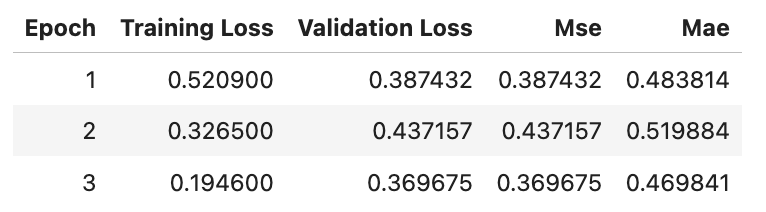

In [ ]:
#! Add the location where you want to save the finetuned writing model

trainer.save_model(
    output_dir="/home/jovyan/active-projects/asap_scoring/fine_tuned_model"
)


## Results
We can assess the performance of the model over a large number of inputs (e.g., the test set). Here, we initially look at the performance of the training set to make sure the model has _learned_ from the data we've provided.

We do the following

**first** we call in the saved dataset and apply it to test set

**second** we run the trained model in the code above (i.e., the model in memory) on the test set (i.e., we do not call in the saved model

### Calling in saved model

This is the easiest solution and will allow you to retrieve saved model as needed without retraining the model using all the steps above

In [ ]:
#call in the saved model

#The chunk above saved three items
# 1. Config.json: Configuration settings for transformer model like the model architecture
# 2. model.safetensors: weights and parameters of the trained transformer model
# 3. training_args.bin: the arguments and settings that were used during the training process of the transformer model
# learning rate, batch size, etc...

# call in a new variable called trainer_saved and use it below for trainer_saved.evaluate and trainer_saved.predict

#set path
PATH = "/home/jovyan/active-projects/asap_scoring/fine_tuned_model"

num_labels = 1 #for regression analysis. This would change with classification
model = AutoModelForSequenceClassification.from_pretrained(PATH, num_labels=num_labels)

In [ ]:
#set up a new trainer

trainer = Trainer(
    model=model, #calls in model
    args=training_args, #calls in training_args from code above 
    data_collator=data_collator, #calls in pre-defined data_collator (see code above)
    train_dataset=asap_dd_tokenized["train"], #! the training dataset
    eval_dataset=asap_dd_tokenized["test"], #! the testing set
    compute_metrics=compute_metrics,
)

#evaluates on test set
trainer.evaluate(
    asap_dd_tokenized["test"]
    )


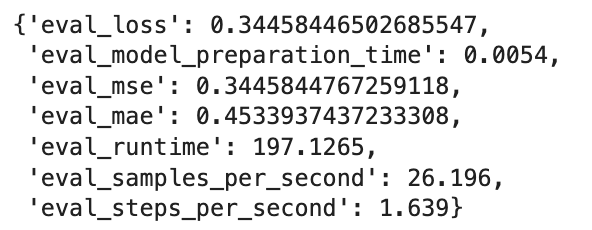


Results from above

### Continue with model that is in memory

This solution works, but if you come back to the code after it has been run and the server has shut down, you will have retrain the model to get the variables.

In [ ]:
# Evaluate the performance of the model on a given dataset (test)

trainer.evaluate(
    asap_dd_tokenized["test"]
    )

**Results**

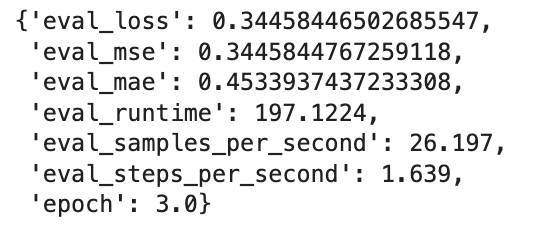

Here's what each of these components is telling us:

* `epoch`: the epoch number at which the evaluation is performed.

* `eval_loss`: the evaluation loss. The evaluation loss is a measure of how well the model performs on the evaluation dataset, with lower values indicating better performance.

* `eval_mse`: Why is this the same as `eval_loss`? Because mean-squared error was our loss function!

* `eval_mae`: Mean Absolute Error

* `eval_runtime`: the total runtime of the evaluation process in seconds.

* `eval_samples_per_second`: the number of samples processed per second.

* `eval_steps_per_second`: the number of batches processed per second.


But the above just gives us summary statistics. Let's get all the individual predictions.

In [ ]:
#Generate predictions using the trained model on a given datase

pred = trainer.predict(
    asap_dd_tokenized["test"]
)

print(pred.predictions)
print(pred.metrics)

[1.3956398 3.624475  2.5796957 ... 2.43714   3.2705112 2.3355937]
{'test_loss': 0.34458446502685547, 'test_mse': 0.3445844767259118, 'test_mae': 0.4533937437233308, 'test_runtime': 198.7241, 'test_samples_per_second': 25.986, 'test_steps_per_second': 1.625}

predictions are an array of floating point values. 

Each of these lists contains a single value for our predicted writing quality score.

In [ ]:
# .reshape(-1) removes an empty dimension
# We get a one-dimensional array (similar to a list)
pred.predictions.reshape(-1)

In [ ]:
# Create a dataframe for inspection
preds_df = pd.DataFrame(
    {
        'predicted':pred.predictions.reshape(-1), # flatten array
        'true':pred.label_ids,
        'text':asap_dd['test']['text'] #! Add the text column of the test partition here
    }
)
display(preds_df.sample(2)) # .sample(2) randomly selects 2 rows

In [ ]:
preds_df.shape

In [ ]:
#save dataframe for later use

preds_df.to_csv('non_hyper_parameterized_results_asap.csv', index=False)

### Statistical Analysis

Linear regression

In [ ]:
# Run the simple linear regression
results = stats.linregress(preds_df["true"], preds_df["predicted"])

# Using an f-string to clearly display and round the relevant output
print(f"R-squared: {results.rvalue**2:.3f}, P-value= {results.pvalue:.3f}")

# Plot the data with a regression line
sns.lmplot(x='true', y='predicted', data=preds_df);

In [ ]:
correlation = np.sqrt(.676)

print(correlation)

**Results**

r = .822
r2 of .676

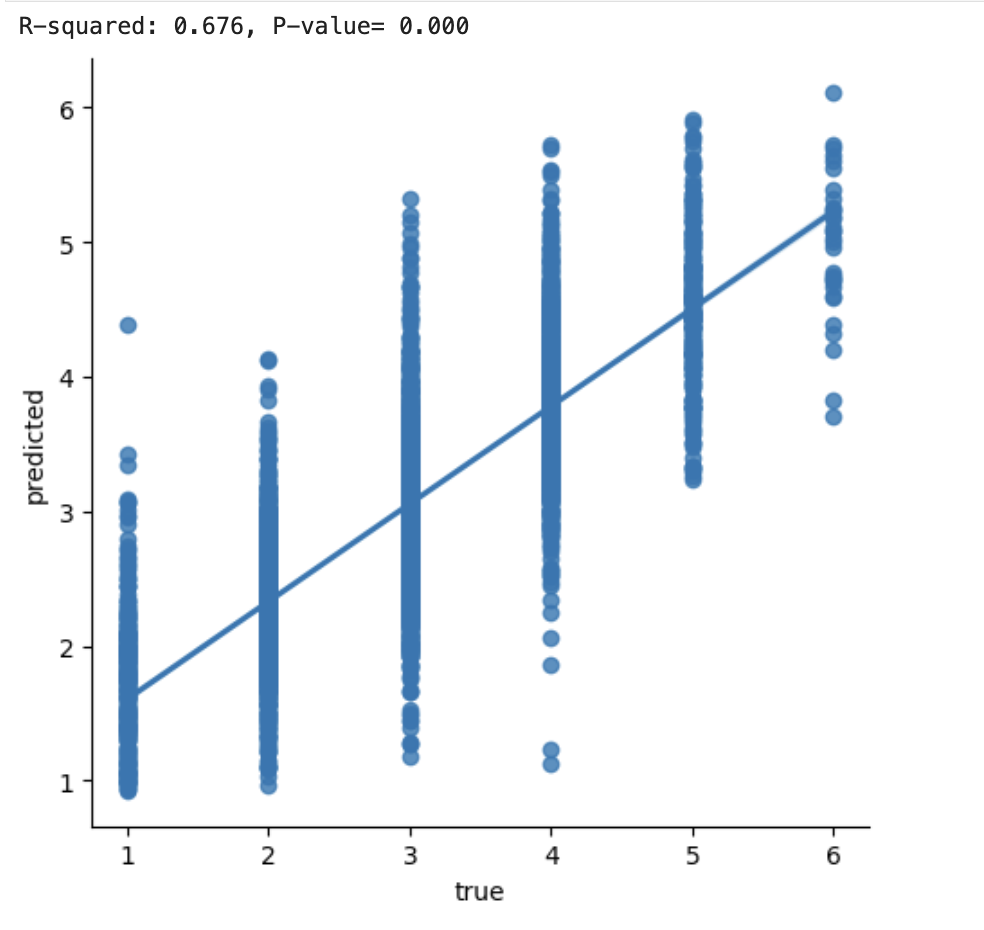


## THE BELOW INVOLVES HYPERPARAMETER TUNING

## Scoring model that has hyperparameters tuned

Remember, that based on the code, we have already

1. Have a dataset with train, dev, and test
2. Tokenized that dataset (asap_dd_tokenized)
3. Set up data_collator



In [15]:
#make sure you have the right tokenzed dataset

asap_dd_tokenized

DatasetDict({
    train: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17307
    })
    dev: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2257
    })
    test: Dataset({
        features: ['label', 'pubpriv', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5164
    })
})

In [24]:
# Import library to track our training runs and change settings during hyperparameter tuning
#!pip install wandb #may require an install

import wandb #(Weights and Biases package)

# Replace the variables below with your own: name, project name, and project directory
#%env WANDB_ENTITY = scott
%env WANDB_PROJECT = asap
%env WANDB_DIR = /home/jovyan/active-projects/asap_scoring/bin
%env WANDB_NOTEBOOK_NAME = /home/jovyan/active-projects/asap_scoring/asap_llm_modeling_baseline.ipynb

score_to_predict = 'label'
model_name='microsoft/deberta-v3-large'

env: WANDB_PROJECT=asap
env: WANDB_DIR=/home/jovyan/active-projects/asap_scoring/bin
env: WANDB_NOTEBOOK_NAME=/home/jovyan/active-projects/asap_scoring/asap_llm_modeling_baseline.ipynb


### Hyperparameter Optimization

Config is based on Appendix A.4:

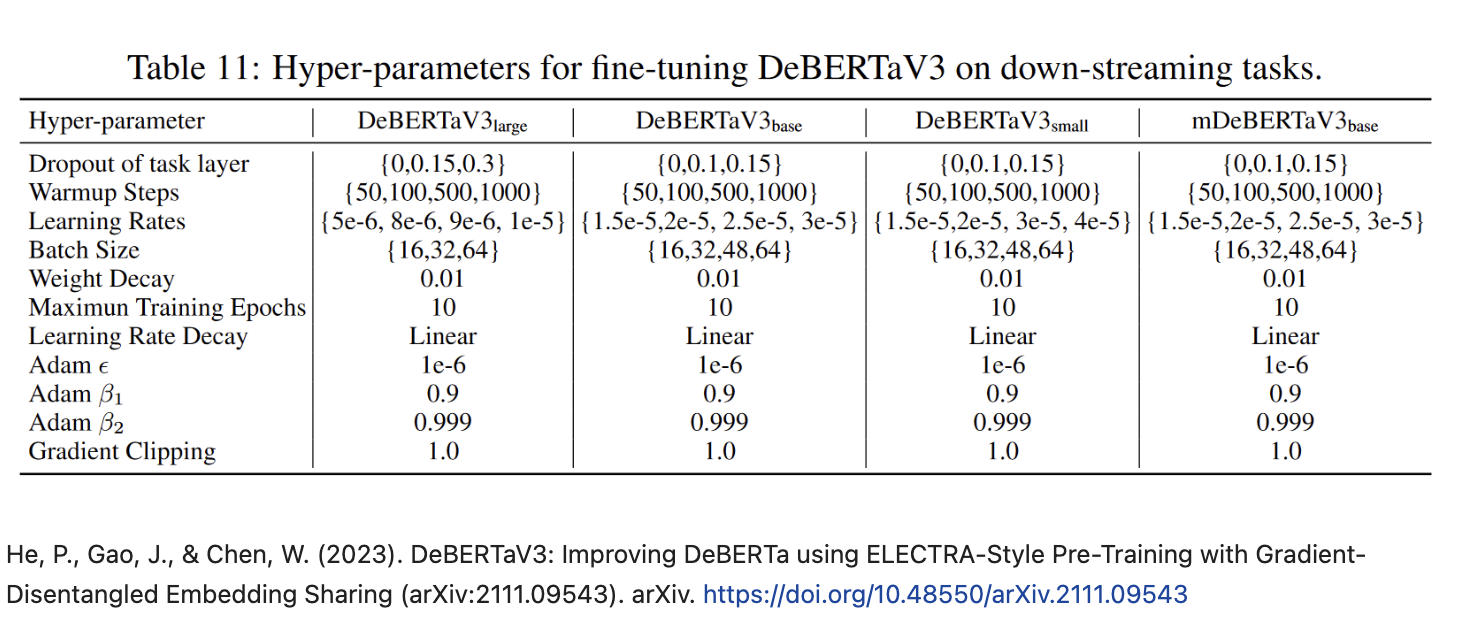

In [17]:
#set up configuration dictionary for a hyperparameter optimization process

sweep_config = {
    'name': f'{score_to_predict}-{model_name}',
    'method': 'bayes', #bayes
    'run_cap': 42, # bayesian optimizer will run until stopped if this is not set
    'metric': {
        'name': f'eval/mse', #mean squared error
        'goal': 'minimize'}, # we want to "minimize" the mean squared error.
    'parameters': {
        'batch_size': {'value': 2}, # batch size of 2 is required due to memory limitations and long sequence lengths
        'gradient_accumulation_steps': {'value': 16}, #fixed scale
        'learning_rate': {'values': [5e-6, 8e-6, 9e-6, 1e-5]},
        'num_train_epochs': {'values': [2, 3, 4, 5]}, # Up to 10 epochs are suggested, so we may need to extend this range if models are still improving at 4-5 epochs.
        'pooler_dropout': {'values': [0, 0.15, 0.30]}, #Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the input units to 0 during training
        'weight_decay': {'value': 0.01}, #hyperparameter that controls the L2 regularization applied to the model's weights during training. L2 regularization is a common technique used to prevent overfitting by adding a penalty term to the loss function, proportional to the square of the model's weights
        'adam_beta1': {'value': 0.900}, #hyperparameters of the Adam optimization algorithm, which is used to update the model's weights during training
        'adam_beta2': {'value': 0.999},
        'adam_epsilon': {'value': 1e-6},
        'warmup_steps': {'values': [50, 100, 500, 1000]}, #hyperparameter that controls the number of initial training steps during which the learning rate is gradually increased from a small value to the full learning rate
    },
}

Create Model Initialization Function

The hyperparameter configuration refers to a dropout layer in the classifier head. Reading through Microsoft's original implementation of DeBERTav3 and the HuggingFace implementation, it seems that we can configure this using the pooler_dropout parameter.



In [18]:
def model_init(config):
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, pooler_dropout=config.pooler_dropout)


In [19]:
#compute metrics

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    mse = mean_squared_error(labels, preds)

    return {'mse': mse}

**Training Arguments**


In [26]:
def train():
    with wandb.init():
        # set sweep configuration
        config = wandb.config

        # Customize the trainer
        training_args = TrainingArguments(
            output_dir = '../bin', 
            optim = 'adamw_torch', # Specify your optimizer
            logging_dir = f'../logs/{score_to_predict}', 
            load_best_model_at_end = True, #load the best model at the end
            metric_for_best_model = 'mse', # We will be using mean squared error to evaluate model performance
            evaluation_strategy='epoch', # Evaluate model performance at the end of each epoch
            save_strategy='epoch', # checkpoints are saved after each epoch 
            #save_strategy='no', # checkpoints are not saved after each epoch saving storage space (this caused an error)
            greater_is_better = False, #mse likes lower
            log_level = 'error', #only error-level messages will be logged
            disable_tqdm = False, #show viz
            report_to='wandb',
            # The hyper parameters we are tuning (umber of epochs, learning rate, and batch size) are called in from the configuration dictionary
            num_train_epochs=config.num_train_epochs,
            warmup_steps=config.warmup_steps,
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=16,
        )

        model = model_init(config)

        # Initialize the trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=asap_dd_tokenized['train'],
            eval_dataset=asap_dd_tokenized['dev'],
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
        )


        # Start training loop
        trainer.train()

In [27]:
#Start HP tuning. This will take a long time since we will be finetuning multiple models and comparing their performances.

#API key e7440dd1b6ac06974286a3c4955668534120df04

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, train)

Create sweep with ID: oxkr5sfr
Sweep URL: https://wandb.ai/scrosseye-vanderbilt-university/asap/sweeps/oxkr5sfr


wandb: Agent Starting Run: wcn0j6mx with config:
wandb: 	adam_beta1: 0.9
wandb: 	adam_beta2: 0.999
wandb: 	adam_epsilon: 1e-06
wandb: 	batch_size: 2
wandb: 	gradient_accumulation_steps: 16
wandb: 	learning_rate: 1e-05
wandb: 	num_train_epochs: 4
wandb: 	pooler_dropout: 0
wandb: 	warmup_steps: 50
wandb: 	weight_decay: 0.01


/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: WARNING Config item 'pooler_dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update)

Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2771, in _evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
              ^^^^^^^^^^^^^

train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,▇▄▂▄▃▂▄▄█▅▃▁▃▁▃▂▂
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/loss,█▃▂▁▂▂▂▂▂▂▂▁▁▁▁▁▂
train/epoch,0.9822
train/global_step,8500
train/grad_norm,13.83602
train/learning_rate,1e-05
train/loss,0.4365


Run wcn0j6mx errored:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING Config item 'pooler_dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored 

Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2771, in _evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
              ^^^^^^^^^^^^^

train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,▅▂▂▅▃▂▄▂█▄▂▃▁▁▃▁▂
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/loss,█▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch,0.9822
train/global_step,8500
train/grad_norm,12.24275
train/learning_rate,0.0
train/loss,0.3952


Run kfbsc664 errored:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING Config item 'pooler_dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored 

Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2771, in _evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
              ^^^^^^^^^^^^^

train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,█▂▅▇▃▃▃▆█▆▄▂▁▁▄▁▃
train/learning_rate,██▇▇▆▆▅▅▄▄▄▃▃▂▂▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,0.9822
train/global_step,8500
train/grad_norm,13.89574
train/learning_rate,1e-05
train/loss,0.4244


Run yrclcb1q errored:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING Config item 'pooler_dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored 

Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2771, in _evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
              ^^^^^^^^^^^^^

train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,▇▂▃▅▂▁▂▄█▄▄▁▂▂▄▁▃
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/loss,█▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁
train/epoch,0.9822
train/global_step,8500
train/grad_norm,13.94804
train/learning_rate,1e-05
train/loss,0.4274


Run jmt4h1a4 errored:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING Config item 'pooler_dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored 

Epoch,Training Loss,Validation Loss


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Traceback (most recent call last):
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics

train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,▅▁▃▆▃▁▃▆█▄▃▁▂▂▃▂▃
train/learning_rate,██▇▇▆▆▅▅▅▄▄▃▃▂▂▁▁
train/loss,█▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
train/epoch,0.9822
train/global_step,8500
train/grad_norm,15.17177
train/learning_rate,1e-05
train/loss,0.4142


Run sgyok2d5 errored:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib

/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING Config item 'pooler_dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta1' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_beta2' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'adam_epsilon' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'warmup_steps' was locked by 'sweep' (ignored 

Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2771, in _evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
              ^^^^^^^^^^^^^

train/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train/grad_norm,▄▁▃▅▃▁▃▄█▄▄▂▁▁▄▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▄▃▃▂▂▁▁
train/loss,█▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch,0.9822
train/global_step,8500
train/grad_norm,10.3874
train/learning_rate,1e-05
train/loss,0.415


Run 1z3eouyf errored:
Traceback (most recent call last):
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_227/3135973015.py", line 42, in train
    trainer.train()
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 1948, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2386, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, grad_norm, model, trial, epoch, ignore_keys_for_eval)
  File "/home/jovyan/conda_envs/hugging_face/lib/python3.12/site-packages/transformers/trainer.py", line 2814, in _maybe_log_save_evaluate
    metrics = self._evaluate(trial, ignore_keys_for_eval)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/conda_envs/hugging_face/lib